In [1]:
import pandas as pd
import os, shutil
import numpy as np

In [2]:
import tensorflow
from tensorflow.compat.v1.keras.backend import set_session
config = tensorflow.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
sess = tensorflow.compat.v1.Session(config=config)
set_session(sess)
import tensorflow.keras.backend as K

tensorflow.compat.v1.disable_eager_execution()

In [3]:
os.chdir("C:/Users/abbal/Documents/Data Science Personal Projects/Py - Bird Classification")

In [4]:
## Create a folder for each set
TTV_Sets = ["test", "train", "validation"]
for st in TTV_Sets:
    os.mkdir(os.path.join("./Categorized" , st))

In [5]:
directory_list = list()
dog_breeds = list()
for root, dirs, files in os.walk("./Raw Images", topdown=False):
    for name in dirs:
        directory_list.append(os.path.join(root, name))
        dog_breeds.append(name)

TTV_Sets = ["train", "test", "validation"]        
for st in TTV_Sets:
    for i in dog_breeds:     
        os.mkdir(os.path.join("./Categorized",st, i))

In [6]:
## split labels to train, test and validation
def train_validate_test_split(array, train_percent=0.60, validate_percent=0.40, seed=1):
    np.random.seed(seed)
    perm = np.random.permutation(array)
    m = len(array)
    train_end = int(train_percent * m)
    validate_end = int(validate_percent * m) + train_end
    train = perm[:train_end]
    validate = perm[train_end:validate_end]
    test = perm[validate_end:]
    return train, validate, test

In [7]:
for fld in range(len(directory_list)):

    TempFLDR = directory_list[fld]
    TempDogBreed = dog_breeds[fld]
    
    ## Get files in folder
    fles = []
    for (dirpath, dirnames, filenames) in os.walk(TempFLDR):
        fles.extend(filenames)
        break

    ## split the files into train, test, validation
    train, validate, test = train_validate_test_split(fles)

    ## Copy each file in their respective folder
    for fle in range(len(train)):
        Orig_file = os.path.join(TempFLDR, train[fle])
        New_file = os.path.join("./Categorized/train",TempDogBreed, train[fle])
        shutil.copyfile(Orig_file, New_file)

    for fle in range(len(validate)):
        Orig_file = os.path.join(TempFLDR, validate[fle])
        New_file = os.path.join("./Categorized/validation",TempDogBreed, validate[fle])
        shutil.copyfile(Orig_file, New_file)

    for fle in range(len(test)):
        Orig_file = os.path.join(TempFLDR, test[fle])
        New_file = os.path.join("./Categorized/test",TempDogBreed, test[fle])
        shutil.copyfile(Orig_file, New_file)
    print(TempDogBreed)        

American Wigeon Bird
Blue-winged Teal Bird
Brant Bird
Cackling Goose Bird
Canada Goose Bird
Canvasback Bird
Cinnamon Teal Bird
Eurasian Wigeon Bird
Fulvous Whistling-Duck Bird
Gadwall Bird
Greater Scaup Bird
Greater White-fronted Goose Bird
Green-winged Teal Bird
Mallard Bird
Mandarin Duck Bird
Mexican Duck Bird
Northern Pintail Bird
Northern Shoveler Bird
Redhead Bird
Ring-necked Duck Bird
Ross's Goose Bird
Snow Goose Bird
Tufted Duck Bird
Tundra Swan Bird
Wood Duck Bird


In [8]:
train_dir = os.path.join("./Categorized", 'train')
validation_dir = os.path.join("./Categorized", 'validation')
test_dir = os.path.join("./Categorized", 'test')

In [9]:
## let's use ResNet50
## Let's also increase the image processing size to 300x300
from keras.applications import InceptionResNetV2

conv_base = InceptionResNetV2(weights='imagenet', 
                              include_top=False,
                              input_shape=(256, 256, 3))

Instructions for updating:
Colocations handled automatically by placer.


In [10]:
from keras import models
from keras import layers

model = models.Sequential()
model.add(conv_base)
model.add(layers.Conv2D(1024, (3, 3), activation='relu'))
model.add(layers.Conv2D(1024, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dense(25, activation='softmax'))

In [11]:
## Fix base model so it doesn't train.
conv_base.trainable = False

In [12]:
from tensorflow.keras import optimizers

model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])

C:\Users\abbal\anaconda3\envs\tf_env\lib\site-packages\keras\optimizers\optimizer_v2\rmsprop.py:140: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_resnet_v2 (Functi  (None, 6, 6, 1536)       54336736  
 onal)                                                           
                                                                 
 conv2d_203 (Conv2D)         (None, 4, 4, 1024)        14156800  
                                                                 
 conv2d_204 (Conv2D)         (None, 2, 2, 1024)        9438208   
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 1, 1, 1024)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 1024)              0         
                                                                 
 dense (Dense)               (None, 1024)              1

In [14]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.applications.inception_v3 import preprocess_input, decode_predictions

## Process images by:
## using inception pre-processing function
## adding some distortion to the images
train_datagen = ImageDataGenerator(
      preprocessing_function=preprocess_input,
      rotation_range=45,
      width_shift_range=0.15,
      height_shift_range=0.15,
      shear_range=0.15,
      zoom_range=0.3,
      horizontal_flip=True,
      fill_mode='nearest')

## Don't validate test images
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(256, 256),
        batch_size=32,
        class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(256, 256),
        batch_size=32,
        class_mode='categorical')

Found 750 images belonging to 25 classes.
Found 499 images belonging to 25 classes.


In [15]:
## Only train for 30 epochs, since that will get us closer to the 90% accuracy
history = model.fit(train_generator,
                    steps_per_epoch=100,
                    epochs=50,
                    validation_data=validation_generator,
                    validation_steps=100)

Epoch 1/50
100/100 [==============================] - ETA: 0s - batch: 49.5000 - size: 31.2800 - loss: 2.5201 - acc: 0.2519

C:\Users\abbal\anaconda3\envs\tf_env\lib\site-packages\keras\engine\training_v1.py:2332: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
C:\Users\abbal\anaconda3\envs\tf_env\lib\site-packages\PIL\Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


100/100 [==============================] - 55s 425ms/step - batch: 49.5000 - size: 31.2800 - loss: 2.5201 - acc: 0.2519 - val_loss: 2.7686 - val_acc: 0.2284
Epoch 2/50
100/100 [==============================] - 36s 361ms/step - batch: 49.5000 - size: 31.1000 - loss: 1.6175 - acc: 0.4904 - val_loss: 2.9095 - val_acc: 0.2703
Epoch 3/50
100/100 [==============================] - 36s 364ms/step - batch: 49.5000 - size: 31.4600 - loss: 1.2610 - acc: 0.5906 - val_loss: 3.5234 - val_acc: 0.2623
Epoch 4/50
100/100 [==============================] - 37s 371ms/step - batch: 49.5000 - size: 31.2800 - loss: 1.0811 - acc: 0.6506 - val_loss: 2.3427 - val_acc: 0.3549
Epoch 5/50
100/100 [==============================] - 38s 380ms/step - batch: 49.5000 - size: 31.1000 - loss: 0.9103 - acc: 0.7061 - val_loss: 2.7831 - val_acc: 0.3578
Epoch 6/50
100/100 [==============================] - 38s 385ms/step - batch: 49.5000 - size: 31.2800 - loss: 0.7707 - acc: 0.7535 - val_loss: 2.5034 - val_acc: 0.3398
Epo

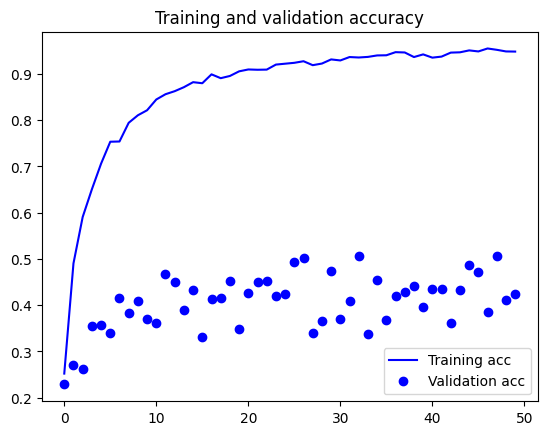

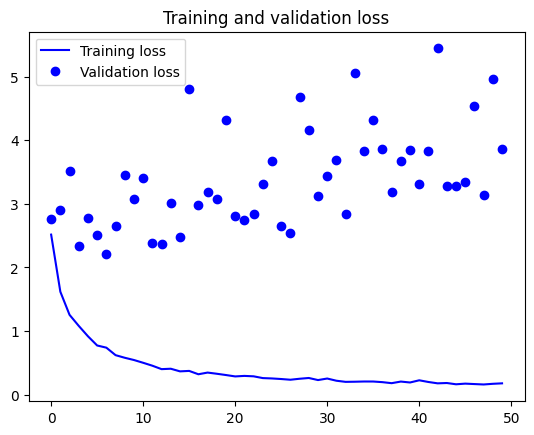

In [16]:
## Let's plot model performance
## Interesting that test performance starts really high
## but doesn't really improve over time.
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'bo', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'bo', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()